In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import pygazeanalyser
import matplotlib
from matplotlib import pyplot as plt
from pygazeanalyser.edfreader import read_edf
from scipy import stats, signal, ndimage
import re
import os
import mne
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.set_printoptions(suppress = True)

In [2]:
# set relevant directories and paths
#workingfolder = '/Users/user/Desktop/Experiments/Nick/AttentionSaccade/' #laptop directory
workingfolder = '/home/sammirc/Experiments/Nick/AttentionSaccade' #workstation directory
eyedat        = os.path.join(workingfolder, 'eyes')
behdat        = os.path.join(workingfolder, 'behaviour/csv')
eegdat        = os.path.join(workingfolder, 'EEG') #only on workstation though, no eeg data on laptop
eyelist       = os.listdir(eyedat)
eyelist       = np.sort(eyelist)
behlist       = np.sort(os.listdir(behdat))
saccadedat    = os.path.join(workingfolder, 'saccades')
if not os.path.exists(saccadedat):
    os.mkdir(saccadedat)
sublist = [4, 5, 6, 7, 8, 9]
parts   = ['a','b']
#1KHz  sample: 1 5 6 7 8 9
#250Hz sample: 4

In [3]:
# specs for the task
resxy = (1920,1080)
scrsize = (60,34)
scrdist = 100 # cm
#pixpcm = np.mean([resxy[0]/scrsize[0],resxy[1]/scrsize[1]])
#samplerate = 1000.0 # Hz , sample every 1ms. subject 4 has 250Hz SR, all other 1kHz
samplerate = 250.0 #for subject 4
# Data files
sep = '\t' #value separator
EDFSTART = "_BEG"
EDFSTOP  = "END"
TRIALORDER = ["B(.*)_T(.*)_BEG","B(.*)_T(.*)_CUE","B(.*)_T(.*)_ARR","B(.*)_T(.*)_RESP","B(.*)_T(.*)_END"]
INVALCODE = np.NaN

In [ ]:
# columns in the behavioural data
# subject  - subject number
# session  - session number
# task     - task type (1 = attention, 2 = saccade)
# cuecol   - 
# cueloc   - cued location (1:8)
# validity - validity of cue (1 = valid, 0 = invalid)
# targloc  - location of target (1:8) - can be same or different to cueloc depending on validity of trial
# targtilt - orientation of target (1 = , 2 = )
# delay    -
# resp     - response made: 0 = no response, 1 = , 2 = 
# time     - NaN on saccade trials (or trials with no response), otherwise RT in seconds
# corr     - accuracy of trial (1 = correct, 0 = incorrect), all saccade trials coded with 0 as no response

In [4]:
edat = []
for sub in range(len(sublist)):
    print('working on S%02d'%(sublist[sub]))
    fname    = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[0]))
    datname  = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[0]))
    bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False)
    edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)

    fname2   = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[1]))
    datname2 = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[1]))
    bdata2   = pd.DataFrame.from_csv(datname2, header=0, sep = ',', index_col=False)
    edata2   = read_edf(fname2, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)

    print('combining S%02d part 1 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
    for trial in range(len(edata)):
        trl  = bdata.iloc[trial,:]
        edata[trial]['behaviour'] = {
            'subject'  : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
            'task'     : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
            'cueloc'   : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
            'targloc'  : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
            'delay'    : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
            'time'     : trl.loc['time']    , 'corr'     : trl.loc['corr']     }
        trigs = edata[trial]['events']['msg']
        if len(trigs) == 4: # attention trial
            trltype = 1 #attention trial
            begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
        elif len(trigs) == 3: #saccade trial, no response
            trltype = 2 #saccade trial
            begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
        #find sample nearest to the trigger time
        begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
        cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
        arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
        if trltype == 1:
            respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
        if trltype == 1: #attention trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],
                "resp"  : [resptrig, respind]}
        if trltype == 2: #saccade trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],}
        edata[trial]['triggers'] = triggers
        # triggers : [EDFTIME, TRIAL_TIME]      
    saccfname = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[0])
    if not os.path.exists(saccfname):    
        print('writing saccade data to file now')
        saccfile     = open(saccfname, 'w')
        saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
            'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
        for trial in range(len(edata)):
            saccades = edata[trial]['events']['Esac']
            tnum = trial + 1
            subject = edata[trial]['behaviour']['subject']
            ttime = edata[trial]['trackertime'][0]
            #saccades[saccade]: start, end, duration, startx, starty, endx, endy
            for saccade in range(len(saccades)):
                saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                     (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                        subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                        saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                        saccades[saccade][5],saccades[saccade][6],saccadevel))
        saccfile.close()
    print('combining S%02d part 2 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
    for trial in range(len(edata2)):
        trl          = bdata2.iloc[trial,:]
        edata2[trial]['behaviour'] = {
            'subject'  : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
            'task'     : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
            'cueloc'   : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
            'targloc'  : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
            'delay'    : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
            'time'     : trl.loc['time']    , 'corr'     : trl.loc['corr']     }
        trigs = edata2[trial]['events']['msg']
        if len(trigs) == 4: # attention trial
            trltype = 1 #attention trial
            begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            resptrig  = edata2[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
        elif len(trigs) == 3: #saccade trial, no response
            trltype = 2 #saccade trial
            begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
        #find sample nearest to the trigger time
        begind  = np.argmin(np.abs(begtrig  - edata2[trial]['trackertime']))
        cueind  = np.argmin(np.abs(cuetrig  - edata2[trial]['trackertime']))
        arrind  = np.argmin(np.abs(arrtrig  - edata2[trial]['trackertime']))
        if trltype == 1:
            respind = np.argmin(np.abs(resptrig - edata2[trial]['trackertime']))
        if trltype == 1: #attention trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],
                "resp"  : [resptrig, respind]}
        if trltype == 2: #saccade trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],}
        edata2[trial]['triggers'] = triggers
        # triggers : [EDFTIME, TRIAL_TIME]  
    saccfname2    = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[1])
    if not os.path.exists(saccfname2):
        print('writing saccade data to file now')
        saccfile2     = open(saccfname2, 'w')
        saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
            'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
        for trial in range(len(edata2)):
            saccades = edata2[trial]['events']['Esac']
            tnum = trial + 1
            subject = edata2[trial]['behaviour']['subject']
            ttime = edata2[trial]['trackertime'][0]
            #saccades[saccade]: start, end, duration, startx, starty, endx, endy
            for saccade in range(len(saccades)):
                saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                     (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                        subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                        saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                        saccades[saccade][5],saccades[saccade][6],saccadevel))
        saccfile2.close()
    comb = edata + edata2
    edat.append(comb)

working on S04
combining S04 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S04 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S05
combining S05 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S05 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S06
combining S06 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S06 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S07
combining S07 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S07 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S08
combining S08 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S08 part 2 eyetracking and behavioural data, and adding trig

In [5]:
# go through every subject and trial to calculate saccadic response time for a given trial
# finds the first saccade of a trial after the target appears ('array' trigger)
# takes the time at which is starts, and subtracts the time at which the array appears, to calculate
# saccade response timek

for isub in range(len(edat)):
    sacctask = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task'] == 2.0]
    for i in sacctask:
        targettrig   = edat[isub][i]['triggers']['array']
        fstime       = edat[isub][i]['trackertime'][0]
        if len(edat[isub][i]['events']['Esac']) > 0:
            trlsaccades  = np.array(edat[isub][i]['events']['Esac']) #extract saccades for trial
            trlsaccades  = trlsaccades[np.argsort(trlsaccades[:,0])] #sort saccades by start time
            inds         = np.squeeze(np.where(trlsaccades[:,0] >= targettrig[0])) # find saccades after probe
            if inds.size > 1:
                firstind = inds[0] #take first saccade after probe
                firstsaccade = trlsaccades[firstind]
                edat[isub][i]['behaviour']['fstime']       = fstime #add first sample time to behavioural data
                edat[isub][i]['behaviour']['firstsaccade'] = firstsaccade #add all saccade data
                edat[isub][i]['behaviour']['saccadetime']  = firstsaccade[0]-fstime - targettrig[1] #add just saccadic response time
            elif inds.size == 1: #only one saccade happened after the probe, so firstind = inds
                firstind = inds # firstind = 0, as only 1 saccade in trial
                firstsaccade = trlsaccades[firstind]
                edat[isub][i]['behaviour']['fstime']       = fstime
                edat[isub][i]['behaviour']['firstsaccade'] = firstsaccade
                edat[isub][i]['behaviour']['saccadetime']  = firstsaccade[0]-fstime - targettrig[1]
            elif inds.size == 0: #no saccades happened after the probe on this trial
                edat[isub][i]['behaviour']['fstime']       = fstime
                edat[isub][i]['behaviour']['firstsaccade'] = np.NaN
                edat[isub][i]['behaviour']['saccadetime']  = np.NaN
        elif len(edat[isub][i]['events']['Esac']) == 0: #no saccades happened on this trial
            edat[isub][i]['behaviour']['fstime']       = fstime
            edat[isub][i]['behaviour']['firstsaccade'] = np.NaN
            edat[isub][i]['behaviour']['saccadetime']  = np.NaN

In [45]:
meanvaltime = []
meaninvtime = []
valids      = []; invalids = []
for isub in range(len(edat)):
    if isub == 0: # subject 4, sample rate was 250hz so saccade onset is out by a factor of 4 (vs. 1000hz sample rate)
        sacval = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==1.0]
        sacinv = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==0.0]
        valtrls = []; invtrls = []
        for i in sacval:
            valtrls.append(edat[isub][i]['behaviour']['saccadetime']/4)
        for i in sacinv:
            invtrls.append(edat[isub][i]['behaviour']['saccadetime']/4)
        valtrials = []; invtrials = []
        valtrlz = [x for x in range(len(valtrls)) if np.isnan(valtrls[x])==False]
        invtrlz = [y for y in range(len(invtrls)) if np.isnan(invtrls[y])==False]
        for i in valtrlz:
            valtrials.append(valtrls[i])
        for i in invtrlz:
            invtrials.append(invtrls[i])
        meanvaltime.append(np.mean(valtrials)); valids.append([valtrials])
        meaninvtime.append(np.mean(invtrials)); invalids.append([invtrials])
    elif isub > 0:
        sacval = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==1.0]
        sacinv = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==0.0]
        valtrls = []; invtrls = []
        for i in sacval:
            valtrls.append(edat[isub][i]['behaviour']['saccadetime'])
        for i in sacinv:
            invtrls.append(edat[isub][i]['behaviour']['saccadetime'])
        valtrials = []; invtrials = []
        valtrlz = [x for x in range(len(valtrls)) if np.isnan(valtrls[x])==False]
        invtrlz = [y for y in range(len(invtrls)) if np.isnan(invtrls[y])==False]
        for i in valtrlz:
            valtrials.append(valtrls[i])
        for i in invtrlz:
            invtrials.append(invtrls[i])
        meanvaltime.append(np.mean(valtrials)); valids.append([valtrials])
        meaninvtime.append(np.mean(invtrials)); invalids.append([invtrials])

valids   = np.squeeze(np.array(valids))
invalids = np.squeeze(np.array(invalids))
id = range(4,10)
meanvaltimedf = pd.DataFrame(meanvaltime); meanvaltimedf['subid'] = id; meanvaltimedf['Validity'] = 'Valid'
meaninvtimedf = pd.DataFrame(meaninvtime); meaninvtimedf['subid'] = id; meaninvtimedf['Validity'] = 'Invalid'
meanvaltimedf.columns = ['ST', 'id', 'Validity']
meaninvtimedf.columns = ['ST', 'id', 'Validity']
plotting    = pd.concat([meanvaltimedf, meaninvtimedf]) #meanvaltime and meaninvtime still contain data

-2.24966093554 0.074308515483


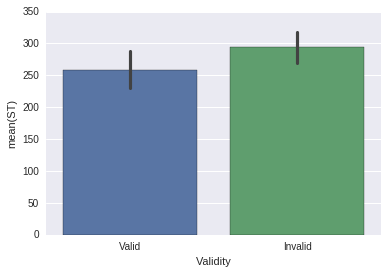

In [28]:
sns.barplot(x = plotting.Validity, y = plotting.ST, ci = 68)
#sns.barplot(x = toplot.Validity, y = toplot.ST, ci = toplot.sem)
#barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
#        estimator=np.mean, ci=95, n_boot=1000, units=None,
#        orient=None, color=None, palette=None, saturation=.75,
#        errcolor=".26", ax=None, **kwargs):
test = stats.ttest_rel(meanvaltime, meaninvtime)
print test.statistic, test.pvalue

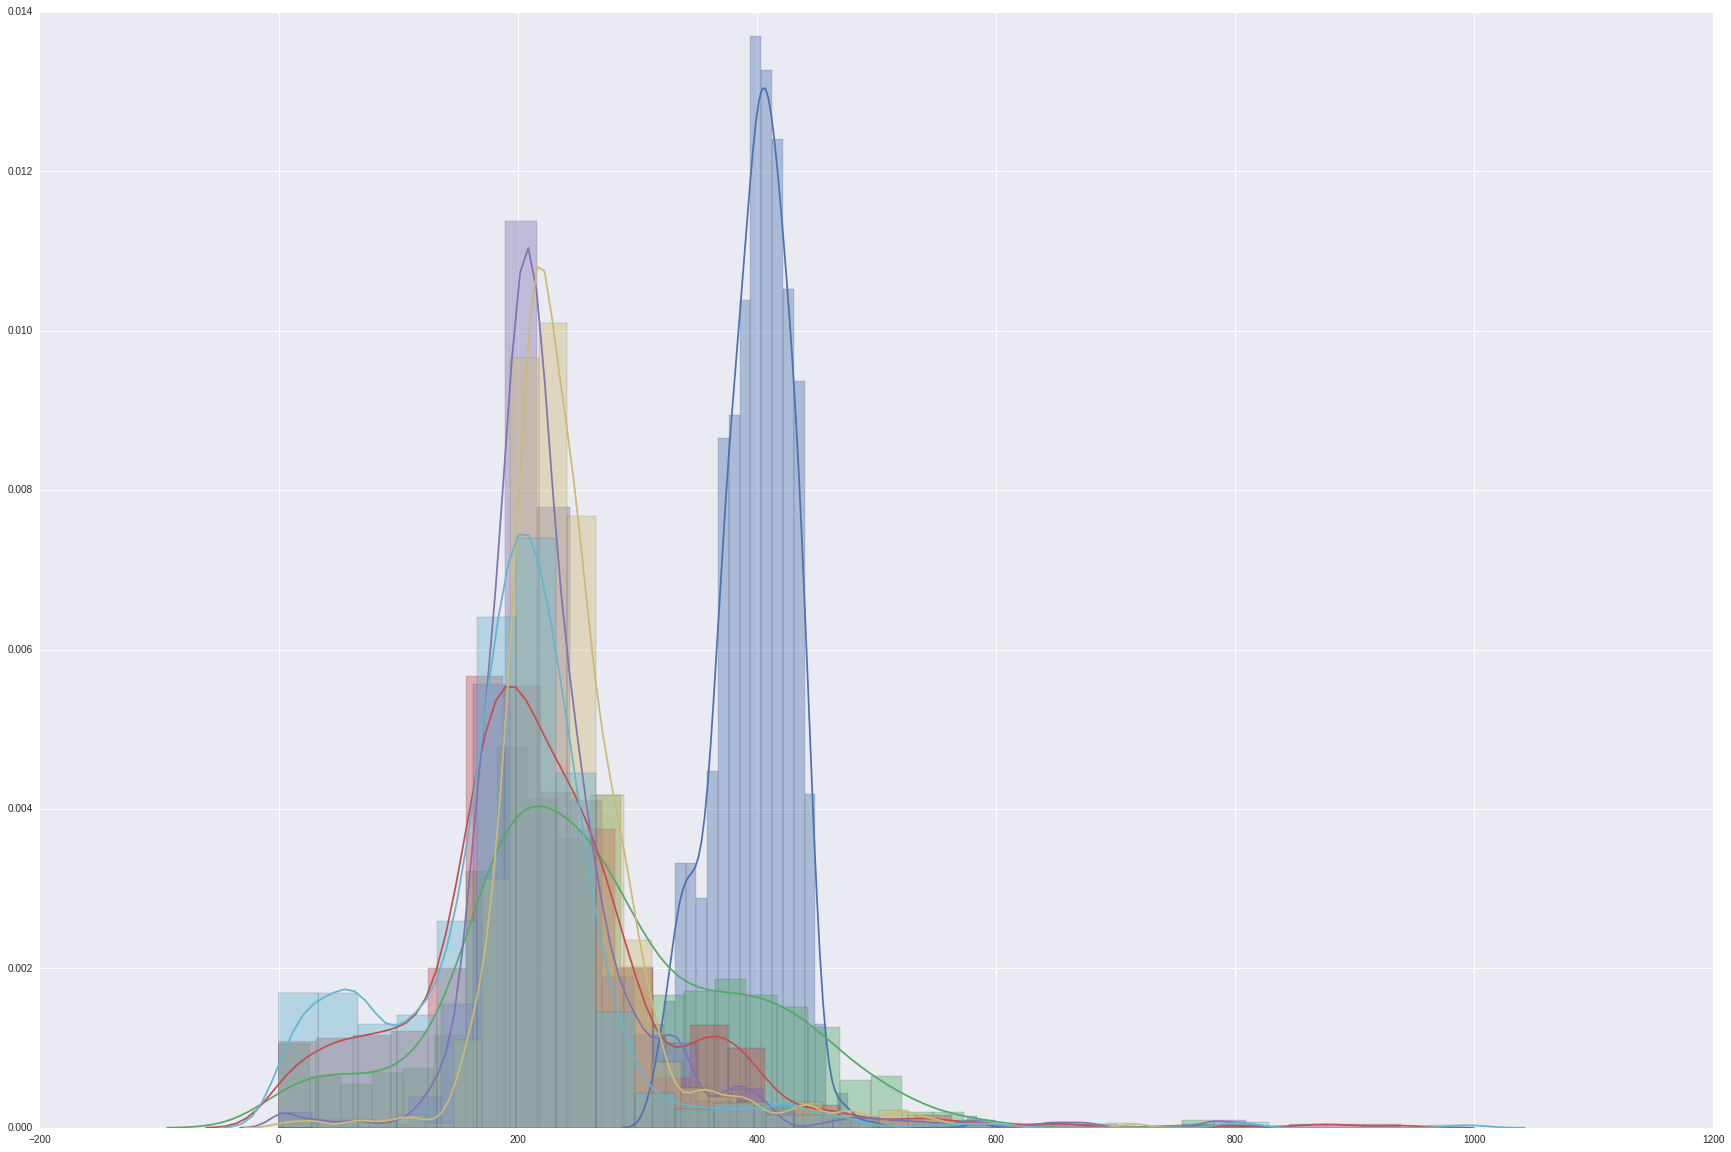

In [56]:
# valids and invalids contains, for each subject
#an array of the valid and invalid single trial saccade times (non-NaN)
plt.rcParams['figure.figsize']=(30,20)
for i in range(len(valids)):
    sns.distplot(valids[i], bins = 30)



In [ ]:
sns.distplot(valtrials, bins = 30)

In [ ]:
trls = []
sacctask = [x for x in range(len(subject)) if subject[x]['behaviour']['task']==2.0]
for i in sacctask:
    trls.append(subject[i]['behaviour']['saccadetime'])
#sactimes = subject[]['behaviour']['saccadetime']

In [ ]:
# edat contains all, both eyetracking and behavioural, but it's computationally 'intensive' to create this
# every time you want to access this data. This structure should be created once only, then output as a
# text file that can be read in, rather than recreating and overwriting certain things each time
# this section will separate edat by subject - edat[0] contains subject 4 data at the moment and then write

# need to find a dataformat that can make each subject data to a file
#that can be read in the subsequent cell replacing the need for some cells above